### Лабораторная работа №4: Деревья решений 
##### Выполнил студент группы: 6131-010402D Павлов Владислав

### 1. Загрузка датасета

In [1]:
import pandas as pd
import sklearn as sk
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz

In [2]:
df = pd.read_csv("big_dataset.csv")

### 2.1 Описание датасета 

#### Большой набор данных о мошенничестве с онлайн-платежами
#### Цель - определить тип транзакции мошенническая или обычная

| Признак | Описание | Единицы измерения |
|:-------:|:--------:|:-----------------:|
| step | Шаг | numerical |
| type | Тип онлайн-транзакции | categorical |
| amount | Сумма транзакции | numerical |
| nameOrig | Клиент, запускающий транзакцию | categorical |
| oldbalanceOrg | Баланс до транзакции | numerical |
| newbalanceOrig | Баланс после транзакции | numerical | 
| nameDest | Получатель транзакции | categorical |
| oldbalanceDest | Баланс получателя до транзакции | numerical |
| newbalanceDest | Баланс получателя после транзакции | numerical |
| isFraud | Мошенническая транзакция  | binary |
| isFlaggedFraud | Флаг транзакции | binary |

##### Целевой класс содержит два значения - 0 или 1, где 0 - обычная транзакция, 1 - мошенническая транзакция



In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,1,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


### Так как датасет очень большой, возьму от исходного 1/80 часть 

In [5]:
df_length = len(df)
part = df_length // 80

part_df = df.sample(n = part)
print(part_df)

         step      type     amount     nameOrig  oldbalanceOrg  \
3981779   298  CASH_OUT   39944.96  C1425733422           0.00   
1573682   155  CASH_OUT  213393.94  C1058104669           0.00   
4769335   334   PAYMENT    9878.28  C1230215202       12022.00   
688784     36  CASH_OUT   91399.57   C884378895       52960.00   
5152617   357  CASH_OUT  174520.75   C512920227           0.00   
...       ...       ...        ...          ...            ...   
1122510   130   PAYMENT    1049.91  C1228513211           0.00   
6040219   487   PAYMENT    8107.76   C520813775           0.00   
1183049   132   PAYMENT   13583.28  C1018875754      303066.00   
4888389   349   CASH_IN  183970.45  C1938129543     1048721.59   
4056083   300  CASH_OUT  251739.34  C2129485629           0.00   

         newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  isFraud  \
3981779            0.00   C662142359       356551.23       396496.19        0   
1573682            0.00  C1953534954     1160

### 2.2 Предобработка данных

In [6]:
part_df.isna().any().any()

False

In [7]:
# Проверка на наличие null
part_df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [8]:
columns_drop = ["step","nameOrig","nameDest", "isFlaggedFraud"]
df_dropped = part_df.drop(columns = columns_drop, axis= 1)


### 2.3 Кодировка категориальных признаков

In [9]:
unique_values = df_dropped["type"].unique()
print(unique_values)

['CASH_OUT' 'PAYMENT' 'CASH_IN' 'TRANSFER' 'DEBIT']


In [10]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df_dropped["type"] = label_encoder.fit_transform(df_dropped["type"])
print(df_dropped["type"].head())


3981779    1
1573682    1
4769335    3
688784     1
5152617    1
Name: type, dtype: int32


### 2.4 Нормализация данных

In [11]:
x = df_dropped.drop("isFraud", axis = 1)
y = df_dropped["isFraud"]

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled_df = pd.DataFrame(x_scaled, columns = x.columns)

In [12]:
x_scaled_df.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,-0.529007,-0.233997,-0.288247,-0.292128,-0.208584,-0.216724
1,-0.529007,0.064982,-0.288247,-0.292128,2.963970,2.813324
2,0.951785,-0.285824,-0.284068,-0.291392,-0.309145,-0.321907
3,-0.529007,-0.145303,-0.269836,-0.292128,0.010609,0.003093
4,-0.529007,-0.002025,-0.288247,-0.292128,3.067094,2.900009


### 2.5 Разбивка выборки на обучающую и тестовую

In [14]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled_df, y, test_size= 0.3, random_state= 42)
print(y_train.shape, y_test.shape)

(55672,) (23860,)


### 3. Дерево решений
#### 3.1 С использованием GridSearchCV осуществить подбор гиперпараметра DesicionTreeClassifier

In [15]:
grid = {
    'max_depth': range(1, x.shape[1]),
    'max_features': range(2, 20),
    'min_samples_leaf': range(5, 20)
}

model = DecisionTreeClassifier()

search = GridSearchCV(model, grid, cv = 5, n_jobs= -1, verbose = 2)
search.fit(x_train, y_train)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6), 'max_features': range(2, 20),
                         'min_samples_leaf': range(5, 20)},
             verbose=2)

### 3.2 Вывести значение гиперпараметра и метрик для наилучшей модели DecisionTreeClassifier

In [20]:
search.best_params_

{'max_depth': 4, 'max_features': 3, 'min_samples_leaf': 14}

In [21]:
best_model = search.best_estimator_
best_model_pred = best_model.predict(x_train)

In [22]:
tree_model_acc = accuracy_score(y_train, best_model_pred)
tree_model_prec = precision_score(y_train, best_model_pred)
tree_model_rec = recall_score(y_train, best_model_pred)
tree_model_f1 = f1_score(y_train, best_model_pred)

print(f"Accuracy: {tree_model_acc}; Precision: {tree_model_prec}; Recall: {tree_model_rec}; F1_score: {tree_model_f1}")

Accuracy: 0.699220433970398; Precision: 0.7142857142857143; Recall: 0.0005969792848188168; F1_score: 0.0011929615269907546


### 3.3 Для получения наилучшего дерева вывести feature_importances, отсортировать по убыванию


In [25]:
feature_importances = best_model.feature_importances_
feature_importance_dict = {feature: importance for feature, importance in zip(x_train.columns, feature_importances)}
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)
print("Отсортированные значения feature_importances по убыванию:")
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance}")

Отсортированные значения feature_importances по убыванию:
oldbalanceDest: 0.41315222524162065
oldbalanceOrg: 0.33048562201033566
newbalanceOrig: 0.18903485368702802
amount: 0.06732729906101578
type: 0.0
newbalanceDest: 0.0


### 3.4 Осуществить фильтрацию признаков 

In [26]:
threshold = np.mean([value for _, value in sorted_feature_importance])
selected_features = [feature for feature, value in sorted_feature_importance if value > threshold]
selected_features

['oldbalanceDest', 'oldbalanceOrg', 'newbalanceOrig']

### 3.5 Подобрать лучшую модель с использованием GridSearchCV на обучающей выборке с отфильтрованными признаками 

In [27]:
x_train_filtered = x_train[selected_features]
# x_train_filtered.head()

search_filtered = GridSearchCV(model, grid, cv = 5, n_jobs= -1, verbose= 2)
search_filtered.fit(x_train_filtered, y_train)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6), 'max_features': range(2, 20),
                         'min_samples_leaf': range(5, 20)},
             verbose=2)

### 3.6 Вывести полученные гиперпараметры лучшей модели

In [28]:
search_filtered.best_params_

{'max_depth': 4, 'max_features': 2, 'min_samples_leaf': 5}

### 3.7 Сравнить метрики до и после фильтрации признаков лучших моделей

In [29]:
best_model_filtered = search_filtered.best_estimator_
best_model_filtered_pred = best_model_filtered.predict(x_train_filtered)

In [30]:
tree_model_filtered_acc = accuracy_score(y_train, best_model_filtered_pred)
tree_model_filtered_prec = precision_score(y_train, best_model_filtered_pred)
tree_model_filtered_rec = recall_score(y_train, best_model_filtered_pred)
tree_model_filtered_f1 = f1_score(y_train, best_model_filtered_pred)

print("Before:")
print(f"Accuracy: {tree_model_acc}; Precision: {tree_model_prec}; Recall: {tree_model_rec}; F1_score: {tree_model_f1}")

print("After:")
print(f"Accuracy: {tree_model_filtered_acc}; Precision: {tree_model_filtered_prec}; Recall: {tree_model_filtered_rec}; F1_score: {tree_model_filtered_f1}")

Before:
Accuracy: 0.699220433970398; Precision: 0.7142857142857143; Recall: 0.0005969792848188168; F1_score: 0.0011929615269907546
After:
Accuracy: 0.6993820951286104; Precision: 0.8947368421052632; Recall: 0.0010148647841919886; F1_score: 0.0020274299344066786


#### После фильтрации признаков метрики улучшились

### 4. Случайный лес
#### 4.1 Построить случайный лес (Random Forest Classifier), с использованием GridSearchCV осуществить подбор гиперпараметра

In [31]:
forest_model = RandomForestClassifier()

forest_grid = {
    'max_depth': range(1, x.shape[1]),
    'n_estimators': range(10, 160, 5)
}

forest_search = GridSearchCV(forest_model, forest_grid, cv = 5, n_jobs= -1, verbose= 2)
forest_search.fit(x_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6),
                         'n_estimators': range(10, 160, 5)},
             verbose=2)

### 4.2 Вывести полученные гиперпараметры лучшей модели случайного леса

In [32]:
forest_search.best_params_

{'max_depth': 5, 'n_estimators': 45}

### 4.3 Осуществить фильтрацию признаков

In [33]:
forest_best_model = forest_search.best_estimator_

In [36]:
forest_features = zip(x_train.columns, forest_best_model.feature_importances_)
forest_features = sorted(forest_features, key = lambda x: x[1], reverse= True)
forest_len_max = max([len(col) for col in x_train.columns])
for name, value in forest_features:
    print(f"{name:<{forest_len_max}} importance: {value:.5f}")


amount         importance: 0.26172
oldbalanceOrg  importance: 0.19934
newbalanceDest importance: 0.19914
oldbalanceDest importance: 0.16912
newbalanceOrig importance: 0.14408
type           importance: 0.02661


In [37]:
forest_threshold = np.mean([value for _, value in forest_features])
forest_selected_features = [feature for feature, value in forest_features if value > forest_threshold]
forest_selected_features

['amount', 'oldbalanceOrg', 'newbalanceDest', 'oldbalanceDest']

### 4.4 Подобрать лучшую модель с использованием GridSearchCV на обучающей выборке с отфильтрованными признаками.

In [38]:
x_train_forest_filtered = x_train[forest_selected_features]
x_train_forest_filtered.head()

,amount,oldbalanceOrg,newbalanceDest,oldbalanceDest
61449,0.233210,-0.284554,-0.134468,-0.197576
47608,0.192575,0.376809,1.304289,1.500848
15222,0.258660,1.608904,-0.264117,-0.155829
63803,-0.224994,-0.281036,-0.321907,-0.309145
26658,0.262315,-0.286814,0.295953,0.391010


In [39]:
forest_search_filtered = GridSearchCV(forest_model, forest_grid, cv = 5, n_jobs= -1, verbose= 2)
forest_search_filtered.fit(x_train_forest_filtered, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 6),
                         'n_estimators': range(10, 160, 5)},
             verbose=2)

### 4.5 Вывести полученные гиперпараметры лучшей модели случайного леса.

In [40]:
forest_search_filtered.best_params_

{'max_depth': 5, 'n_estimators': 70}

### 4.6 Сравнить метрики до и после фильтрации признаков лучших моделей.

In [41]:
forest_best_model_filtered = forest_search_filtered.best_estimator_

In [42]:
forest_model_predict = forest_best_model.predict(x_train)
forest_model_filtered_prediict = forest_best_model_filtered.predict(x_train_forest_filtered)

forest_model_acc = accuracy_score(y_train, forest_model_predict)
forest_model_prec = precision_score(y_train, forest_model_predict)
forest_model_rec = recall_score(y_train, forest_model_predict)
forest_model_f1 = f1_score(y_train, forest_model_predict)

forest_model_filtered_acc = accuracy_score(y_train, forest_model_filtered_prediict)
forest_model_filtered_prec = precision_score(y_train, forest_model_filtered_prediict)
forest_model_filtered_rec = recall_score(y_train, forest_model_filtered_prediict)
forest_model_filtered_f1 = f1_score(y_train, forest_model_filtered_prediict)


print("Before:")
print(f"Accuracy: {forest_model_acc}; Precision: {forest_model_prec}; Recall: {forest_model_rec}; F1_score: {forest_model_f1}")

print("After:")
print(f"Accuracy: {forest_model_filtered_acc}; Precision: {forest_model_filtered_prec}; Recall: {forest_model_filtered_rec}; F1_score: {forest_model_filtered_f1}")

Before:
Accuracy: 0.6995617186377353; Precision: 1.0; Recall: 0.001492448212047042; F1_score: 0.0029804482594182166
After:
Accuracy: 0.6994180198304354; Precision: 1.0; Recall: 0.0010148647841919886; F1_score: 0.0020276717557251907


#### Можно сказать, что метрики незначительно ухудшились

### 5. Метод ближайших соседей
#### 5.1 С использованием GridSearchCV осуществить подбор гиперпараметра KNeighborsClassifier (n_neighbors).

In [43]:
knn_model = KNeighborsClassifier()

In [44]:
knn_grid = {'n_neighbors': range(2, 50)}

knn_search = GridSearchCV(knn_model, knn_grid, cv = 5, n_jobs=-1, verbose=2)
knn_search.fit(x_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(2, 50)}, verbose=2)

### 5.2 Вывести значения гиперпараметра и метрик для наилучшей модели.

In [45]:
knn_search.best_params_

{'n_neighbors': 48}

### 5.3 Осуществить фильтрацию признаков.

In [46]:
knn_filtered = forest_selected_features
x_train_knn_filtered = x_train[knn_filtered]
x_train_knn_filtered.head()

,amount,oldbalanceOrg,newbalanceDest,oldbalanceDest
61449,0.233210,-0.284554,-0.134468,-0.197576
47608,0.192575,0.376809,1.304289,1.500848
15222,0.258660,1.608904,-0.264117,-0.155829
63803,-0.224994,-0.281036,-0.321907,-0.309145
26658,0.262315,-0.286814,0.295953,0.391010


### 5.4 Подобрать лучшую модель с использованием GridSearchCV на обучающей выборке с отфильтрованными признаками.

In [47]:
knn_search_filtered = GridSearchCV(knn_model, knn_grid, cv = 5, n_jobs= -1, verbose= 2)
knn_search_filtered.fit(x_train_knn_filtered, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(2, 50)}, verbose=2)

### 5.5 Вывести полученные гиперпараметры лучшей модели случайного леса.

In [48]:
knn_search_filtered.best_params_

{'n_neighbors': 48}

### 5.6 Сравнить метрики до и после фильтрации признаков.

In [49]:
knn_best_model = knn_search.best_estimator_
knn_best_model_filtered = knn_search_filtered.best_estimator_

In [50]:
knn_model_predict = knn_best_model.predict(x_train)
knn_model_filtered_prediict = knn_best_model_filtered.predict(x_train_knn_filtered)

knn_model_acc = accuracy_score(y_train, knn_model_predict)
knn_model_prec = precision_score(y_train, knn_model_predict)
knn_model_rec = recall_score(y_train, knn_model_predict)
knn_model_f1 = f1_score(y_train, knn_model_predict)

knn_model_filtered_acc = accuracy_score(y_train, knn_model_filtered_prediict)
knn_model_filtered_prec = precision_score(y_train, knn_model_filtered_prediict)
knn_model_filtered_rec = recall_score(y_train, knn_model_filtered_prediict)
knn_model_filtered_f1 = f1_score(y_train, knn_model_filtered_prediict)


print("Before:")
print(f"Accuracy: {knn_model_acc}; Precision: {knn_model_prec}; Recall: {knn_model_rec}; F1_score: {knn_model_f1}")

print("After:")
print(f"Accuracy: {knn_model_filtered_acc}; Precision: {knn_model_filtered_prec}; Recall: {knn_model_filtered_rec}; F1_score: {knn_model_filtered_f1}")

Before:
Accuracy: 0.6992383963213106; Precision: 0.6; Recall: 0.0012536564981195152; F1_score: 0.0025020850708924102
After:
Accuracy: 0.6992743210231355; Precision: 0.5789473684210527; Recall: 0.0019700316399020954; F1_score: 0.003926701570680628


### метрики accuracy, recall и f1-score немного улучшились

### 6. Если наблюдается улучшение метрик после фильтрации признаков хотя бы для одной из моделей, то для набора отфильтрованных признаков заново построить наилучшие модели KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier, сравнить модели в пункте 7 на одинаковом полученном наборе отфильтрованных признаков. Иначе – пропустить этот пункт.

### Есть модели, в которых метрики после фильтрации призаков улучшились. В качестве набора отфильтрованных признаков возьму forest_selected_features

In [51]:
x_train_filt = x_train[forest_selected_features]
x_train_forest_filt = x_train[forest_selected_features]
x_train_knn_filt = x_train[forest_selected_features]

search_filt = GridSearchCV(model, grid, cv = 5, n_jobs= -1, verbose= 2)
search_filt.fit(x_train_filt, y_train)

forest_search_filt = GridSearchCV(forest_model, forest_grid, cv = 5, n_jobs= -1, verbose = 2)
forest_search_filt.fit(x_train_forest_filt, y_train)

knn_search_filt = GridSearchCV(knn_model, knn_grid, cv = 5, n_jobs= -1, verbose= 2)
knn_search_filt.fit(x_train_knn_filt, y_train)

Fitting 5 folds for each of 1350 candidates, totalling 6750 fits
Fitting 5 folds for each of 150 candidates, totalling 750 fits
Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': range(2, 50)}, verbose=2)

### 7. Оценка качества построенных моделей
#### 7.1 Визуализировать любое полученное дерево решений.

[Text(0.5625, 0.9, 'newbalanceOrig <= 9.422\ngini = 0.421\nsamples = 55672\nvalue = [38921, 16751]\nclass = Secondary'),
 Text(0.5, 0.7, 'oldbalanceOrg <= 7.781\ngini = 0.421\nsamples = 55645\nvalue = [38907, 16738]\nclass = Secondary'),
 Text(0.25, 0.5, 'oldbalanceOrg <= 7.454\ngini = 0.421\nsamples = 55511\nvalue = [38798, 16713]\nclass = Secondary'),
 Text(0.125, 0.3, 'oldbalanceDest <= -0.196\ngini = 0.421\nsamples = 55476\nvalue = [38779, 16697]\nclass = Secondary'),
 Text(0.0625, 0.1, 'gini = 0.418\nsamples = 34539\nvalue = [24265, 10274]\nclass = Secondary'),
 Text(0.1875, 0.1, 'gini = 0.425\nsamples = 20937\nvalue = [14514, 6423]\nclass = Secondary'),
 Text(0.375, 0.3, 'oldbalanceDest <= -0.119\ngini = 0.496\nsamples = 35\nvalue = [19, 16]\nclass = Secondary'),
 Text(0.3125, 0.1, 'gini = 0.408\nsamples = 14\nvalue = [4, 10]\nclass = New building'),
 Text(0.4375, 0.1, 'gini = 0.408\nsamples = 21\nvalue = [15, 6]\nclass = Secondary'),
 Text(0.75, 0.5, 'amount <= -0.099\ngini = 0.

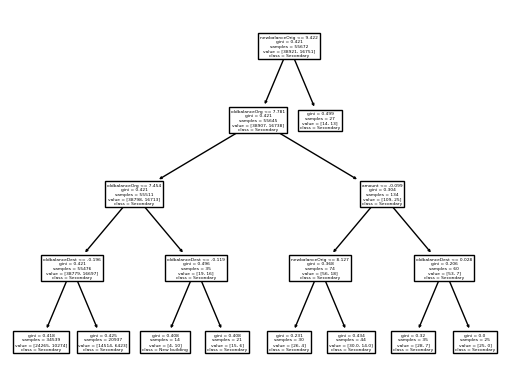

In [52]:
plot_tree(decision_tree=best_model, feature_names=x_train.columns, class_names=['Secondary','New building'])

### 7.2 Сравнения моделей на одинаковом наборе после фильтрации

In [53]:
decision_best_model_filtereds = search_filt.best_estimator_
forest_best_model_filtereds = forest_search_filt.best_estimator_
knn_best_model_filtereds = knn_search_filt.best_estimator_

In [54]:
decision_model_filtered_predict = decision_best_model_filtereds.predict(x_train_filt)
forest_model_filtered_predict = forest_best_model_filtereds.predict(x_train_forest_filt)
knn_model_filtered_predict = knn_best_model_filtereds.predict(x_train_knn_filt)

decision_model_acc = accuracy_score(y_train, decision_model_filtered_predict)
forest_model_acc = accuracy_score(y_train, forest_model_filtered_predict)
knn_model_acc = accuracy_score(y_train, knn_model_filtered_predict)

decision_model_prec = precision_score(y_train, decision_model_filtered_predict)
forest_model_prec = precision_score(y_train, forest_model_filtered_predict)
knn_model_prec = precision_score(y_train, knn_model_filtered_predict)

decision_model_rec = recall_score(y_train, decision_model_filtered_predict)
forest_model_rec = recall_score(y_train, forest_model_filtered_predict)
knn_model_rec = recall_score(y_train, knn_model_filtered_predict)

decision_model_f1 = f1_score(y_train, decision_model_filtered_predict)
forest_model_f1 = f1_score(y_train, forest_model_filtered_predict)
knn_model_f1 = f1_score(y_train, knn_model_filtered_predict)



print('-----------DECISION TREE-----------')
print(f"Accuracy: {decision_model_acc}; Precision: {decision_model_prec}; Recall: {decision_model_rec}; F1_score: {decision_model_f1}")
print('-----------RANDOM FOREST-----------')
print(f"Accuracy: {forest_model_acc}; Precision: {forest_model_prec}; Recall: {forest_model_rec}; F1_score: {forest_model_f1}")
print('-----------KNN-----------')
print(f"Accuracy: {knn_model_acc}; Precision: {knn_model_prec}; Recall: {knn_model_rec}; F1_score: {knn_model_f1}")

-----------DECISION TREE-----------
Accuracy: 0.699256358672223; Precision: 0.9; Recall: 0.0005372813563369351; F1_score: 0.0010739216037229282
-----------RANDOM FOREST-----------
Accuracy: 0.6995437562868229; Precision: 1.0; Recall: 0.0014327502835651603; F1_score: 0.0028614008941877794
-----------KNN-----------
Accuracy: 0.6992743210231355; Precision: 0.5789473684210527; Recall: 0.0019700316399020954; F1_score: 0.003926701570680628


### 7.3 Сравнить лучшие модели KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier на тестовой выборке. Привести значения метрик.

In [55]:
best_model_pred = best_model.predict(x_test)
forest_model_predict = forest_best_model.predict(x_test)
knn_model_predict = knn_best_model.predict(x_test)


tree_model_acc = accuracy_score(y_test, best_model_pred)
tree_model_prec = precision_score(y_test, best_model_pred)
tree_model_rec = recall_score(y_test, best_model_pred)
tree_model_f1 = f1_score(y_test, best_model_pred)

forest_model_acc = accuracy_score(y_test, forest_model_predict)
forest_model_prec = precision_score(y_test, forest_model_predict)
forest_model_rec = recall_score(y_test, forest_model_predict)
forest_model_f1 = f1_score(y_test, forest_model_predict)

knn_model_acc = accuracy_score(y_test, knn_model_predict)
knn_model_prec = precision_score(y_test, knn_model_predict)
knn_model_rec = recall_score(y_test, knn_model_predict)
knn_model_f1 = f1_score(y_test, knn_model_predict)


print('-----------DECISION TREE-----------')
print(f"Accuracy: {tree_model_acc}; Precision: {tree_model_prec}; Recall: {tree_model_rec}; F1_score: {tree_model_f1}")
print('-----------RANDOM FOREST-----------')
print(f"Accuracy: {forest_model_acc}; Precision: {forest_model_prec}; Recall: {forest_model_rec}; F1_score: {forest_model_f1}")
print('-----------KNN-----------')
print(f"Accuracy: {knn_model_acc}; Precision: {knn_model_prec}; Recall: {knn_model_rec}; F1_score: {knn_model_f1}")

-----------DECISION TREE-----------
Accuracy: 0.6981559094719195; Precision: 0.2727272727272727; Recall: 0.00041684035014589413; F1_score: 0.000832408435072142
-----------RANDOM FOREST-----------
Accuracy: 0.6986169321039396; Precision: 1.0; Recall: 0.0008336807002917883; F1_score: 0.001665972511453561
-----------KNN-----------
Accuracy: 0.698113998323554; Precision: 0.36363636363636365; Recall: 0.0011115742670557178; F1_score: 0.0022163734589278295


### можно сказать, что на тестовом наборе данных, модель "Random Forest" выдает лучше accuracy и precision, а модель "KNN" лучше recall и f1-score